In [66]:
from __future__ import print_function, division

import torch
import torch.utils.data as data
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import numpy as np
import time
import os
import os.path
import math

import skimage.io as io
from skimage.transform import resize

import random
from random import shuffle

from PIL import Image
import matplotlib.pyplot as plt

from sympy.utilities.iterables import multiset_permutations
%matplotlib inline

In [67]:
transform_tensor = transforms.ToTensor()

transform_pil = transforms.ToPILImage()

def createPatch(img, size): 
    patches = torch.rand(9,3,64,64) 
    count = 0
#     print(img.size())
    img = transform_pil(torch.squeeze(img))
    w, h = img.size 
    tw = 64 
    th = 64 
    for w1 in range(0, w, int(w/3)): 
        for h1 in range(0, h, int(h/3)): 
            w2 = w1 + int(np.random.uniform(1, int(w/3) - tw)) 
            h2 = h1 + int(np.random.uniform(1 , int(h/3) - th)) 
            patches[count] = transform_tensor(img.crop((w2, h2, w2 + tw, h2 + tw)))
            count = count + 1
            
    return patches

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def getPermutations():
    permute = []
    arr = np.array([0,1,2,3,4,5,6,7,8])
    for p in multiset_permutations(arr):
        permute.append(p)
    random.shuffle(permute)
    top100 = permute[:100]
    return top100

def getRandomPatch(input_patch, perm_idx):
    for i, each_patch in enumerate(input_patch):
        randomizePatch[i] = patch[perm_torch[perm_idx][i]]
    return randomizePatch

# Get top100 permutations
perm_torch = torch.from_numpy(np.asarray(getPermutations()))
# print(perm_torch.size())

In [68]:
data_dir = './data/'

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(225),
        transforms.RandomCrop(225),
        transforms.ToTensor(),
    ]),
    
    'val': transforms.Compose([
        transforms.Scale(225),
        transforms.RandomCrop(225),
        transforms.ToTensor(),
    ]),
}

dsets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dset_loaders = {
    x: torch.utils.data.DataLoader(dsets[x], batch_size = 1, shuffle = True, num_workers=4)
    for x in ['train', 'val']
}

dset_sizes = {
    x: len(dsets[x])
    for x in ['train', 'val']
}

dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()
    
inputs, classes = next(iter(dset_loaders['train']))

patch = createPatch(inputs, 64)
# print(patch[0].size())
# plt.imshow(transform_pil(patch[8]))

randomizePatch = patch.clone().zero_()

for perm_idx in range(len(perm_torch)):
    randomizePatch = getRandomPatch(patch, perm_idx)
    
# plt.imshow(transform_pil(randomizePatch[8]))

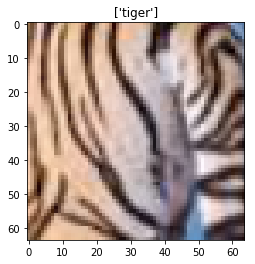

In [87]:
out = torchvision.utils.make_grid(randomizePatch[4])

imshow(out, title = [dset_classes[x] for x in classes])

In [160]:
class SiameseAlex(nn.Module):

    def __init__(self, num_classes=1000):
        super(SiameseAlex, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(4 * 4 * 256, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(9 * 1024, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 100),
        )
        
    def forward_once(self, x):
        x = self.cnn(x)
#       x.size() = torch.Size([1, 256, 2, 2])
        x = x.view(x.size(0), 4 * 4 * 256)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2, input3, input4, input5, input6, input7, input8, input9):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        output4 = self.forward_once(input4)
        output5 = self.forward_once(input5)
        output6 = self.forward_once(input6)
        output7 = self.forward_once(input7)
        output8 = self.forward_once(input8)
        output9 = self.forward_once(input9)
        # concatenate the features
        concat_output = torch.cat((output1, output2, output3, output4, output5, output6, output7, output8, output9),1)
#         print(concat_output.size())
        output = self.classifier(concat_output)
        return output
    
siameseAlex = SiameseAlex()

if torch.cuda.is_available():
    siameseAlex.cuda()

In [161]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(siameseAlex.parameters(), lr=0.001, momentum=0.9)

In [162]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=10):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data
                
                # create patch for each image
                patch = createPatch(inputs, 64)

                # initialize randomizePatch similar to patch with zeros
                randomizePatch = patch.clone().zero_()

                # randomize patches based on permutation
                for perm_idx in range(len(perm_torch)):
                    randomizePatch = getRandomPatch(patch, perm_idx)
                
                    # wrap them in Variable
                    if use_gpu:
                        finalInputs, finalLabels = Variable(randomizePatch.cuda()), \
                            Variable(torch.Tensor([perm_idx]).long().cuda)
                    else:
                        finalInputs, finalLabels = Variable(randomizePatch), \
                            Variable(torch.Tensor([perm_idx]).long())
                        

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(finalInputs[0].unsqueeze(0),finalInputs[1].unsqueeze(0),finalInputs[2].unsqueeze(0),finalInputs[3].unsqueeze(0),finalInputs[4].unsqueeze(0),\
                                   finalInputs[5].unsqueeze(0),finalInputs[6].unsqueeze(0),finalInputs[7].unsqueeze(0),finalInputs[8].unsqueeze(0))
                    
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, finalLabels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == finalLabels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [163]:
model_ft = train_model(siameseAlex, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
LR is set to 0.001
train Loss: 4.6274 Acc: 0.0000
val Loss: 4.6223 Acc: 0.0000

Epoch 1/4
----------
train Loss: 4.6222 Acc: 0.0000
val Loss: 4.6188 Acc: 0.0000

Epoch 2/4
----------
train Loss: 4.6167 Acc: 0.0000
val Loss: 4.6168 Acc: 0.0000

Epoch 3/4
----------
train Loss: 4.6217 Acc: 0.0000
val Loss: 4.6185 Acc: 0.0000

Epoch 4/4
----------
train Loss: 4.6168 Acc: 0.0000
val Loss: 4.6146 Acc: 0.0000

Training complete in 175m 39s
Best val Acc: 0.000000


In [145]:
# For testing purpose
# Please ignore this section
for data in dset_loaders['train']:
    inputs, labels = data
    patch = createPatch(inputs, 64)
    
    #initialize randomizePatch similar to patch with zeros
    randomizePatch = patch.clone().zero_()

    for perm_idx in range(len(perm_torch)):
        randomizePatch = getRandomPatch(patch, perm_idx)
        finalLabels = Variable(torch.Tensor([perm_idx]).long())
        finalInputs = Variable(randomizePatch)
        
        print(finalInputs[0])
        break
    break

Variable containing:
(0 ,.,.) = 
  0.7647  0.5294  0.1098  ...   0.5059  0.5647  0.5608
  0.7333  0.4941  0.1020  ...   0.5255  0.5647  0.5608
  0.7059  0.5020  0.1059  ...   0.4980  0.5098  0.5137
           ...             ⋱             ...          
  0.6784  0.7647  0.7255  ...   0.7373  0.6510  0.4667
  0.7333  0.6588  0.7882  ...   0.6863  0.6549  0.5922
  0.7608  0.7647  0.7765  ...   0.6196  0.5490  0.6157

(1 ,.,.) = 
  0.5843  0.4275  0.0667  ...   0.4039  0.4235  0.4314
  0.5569  0.4000  0.0627  ...   0.4157  0.4078  0.4157
  0.5333  0.4157  0.0667  ...   0.3765  0.3412  0.3608
           ...             ⋱             ...          
  0.6000  0.6863  0.6510  ...   0.6157  0.5255  0.3412
  0.6588  0.5843  0.7137  ...   0.5804  0.5333  0.4706
  0.6902  0.6902  0.6941  ...   0.5569  0.5059  0.5765

(2 ,.,.) = 
  0.3647  0.2549  0.0392  ...   0.2667  0.2431  0.2667
  0.3373  0.2235  0.0353  ...   0.2667  0.2157  0.2431
  0.3098  0.2314  0.0353  ...   0.2275  0.1412  0.1725
      